# KNN and Decision Tree Classifications with validation and up/down sampling

## Import packages and define utility functions

In [1]:
import pandas as pd

#import numpy as np;
#import scipy;

## plotting libraries
from matplotlib import pyplot as plt

## Sklearn libraries
from sklearn import model_selection
from sklearn import metrics as metrics
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree


import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
def model_eval(yt,ypt, yT,ypT):
    return pd.DataFrame({'Error_metric': ['Accuracy','Precision','Recall'],
                               'Train': [accuracy_score(yt, ypt),
                                         precision_score(yt, ypt),
                                         recall_score(yt, ypt)],
                               'Test': [accuracy_score(yT, ypT),
                                        precision_score(yT, ypT),
                                        recall_score(yT, ypT)]})

In [3]:
def fill_nans_with_means(df,col):
    ''' fills nans in column with mean '''
    return df[col].fillna(df[col].mean()).round()

## Read and clean data

In [4]:
churnData = pd.read_csv('DATA_Customer-Churn.csv') # import data frame 

In [5]:
churnData.dtypes  # explore data types

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [6]:
churnData.isnull().any() # check for null values

gender              False
SeniorCitizen       False
Partner             False
Dependents          False
tenure              False
PhoneService        False
OnlineSecurity      False
OnlineBackup        False
DeviceProtection    False
TechSupport         False
StreamingTV         False
StreamingMovies     False
Contract            False
MonthlyCharges      False
TotalCharges        False
Churn               False
dtype: bool

In [7]:
churnData.empty

False

In [8]:
churnData.isnull().values.any()

False

In [9]:
# there are empty values, however. For example 
churnData['TotalCharges'].loc[488] 

' '

In [10]:
# convert to float (nan)
churnData.TotalCharges = pd.to_numeric(churnData.TotalCharges, errors='coerce').astype('float64') 
churnData.isnull().any() # check for null values
churnData.isnull().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

Tenure: time client has been in a contract

In [11]:
# feature selection
churnData = churnData.drop(labels=['gender','Partner','Dependents','PhoneService','OnlineSecurity','OnlineBackup',\
                              'DeviceProtection', 'Contract','TechSupport','StreamingTV','StreamingMovies'], axis=1) # drop customer label
churnData.columns

Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn'], dtype='object')

In [12]:
churnData['TotalCharges']=fill_nans_with_means(churnData,'TotalCharges') # fill nans with means 

In [13]:
# X,y split
y = churnData.Churn
X = churnData.drop(labels=['Churn'],axis=1)

In [14]:
y

0        No
1        No
2       Yes
3        No
4       Yes
       ... 
7038     No
7039     No
7040     No
7041    Yes
7042     No
Name: Churn, Length: 7043, dtype: object

In [15]:
y.replace({'No': 0, 'Yes': 1},inplace=True)

In [16]:
y.value_counts()

0    5174
1    1869
Name: Churn, dtype: int64

In [17]:
X.dtypes

SeniorCitizen       int64
tenure              int64
MonthlyCharges    float64
TotalCharges      float64
dtype: object

In [18]:
R_STATE = 32
TS = .30

In [19]:
# define the models
knnC = KNeighborsClassifier
dtC  = DecisionTreeClassifier

## KNN 

In [20]:
# select 30% for training
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=TS,random_state=R_STATE)

In [21]:
# transform the data to have zero mean and unit variance
std_scaler = StandardScaler().fit(X_train) 
X_train_scaled = std_scaler.transform(X_train)
X_test_scaled = std_scaler.transform(X_test)

In [22]:
y_test.value_counts()

0    1498
1     615
Name: Churn, dtype: int64

### Evaluation 

In [23]:
N_NEIGHS = 3

In [24]:
# model with KNN using 2 neighbors for clustering
model = knnC(n_neighbors=N_NEIGHS, weights='uniform')
model.fit(X_train_scaled, y_train)


y_pred_test = model.predict(X_test_scaled)
y_pred_train = model.predict(X_train_scaled)

In [25]:
pd.DataFrame(y_pred_test).value_counts()

0    1594
1     519
dtype: int64

In [26]:
model_eval(y_train, y_pred_train, y_test, y_pred_test) # get model errors

,Error_metric,Train,Test
0,Accuracy,0.857606,0.747279
1,Precision,0.754613,0.578035
2,Recall,0.652313,0.487805


In [27]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.80      0.85      0.83      1498
           1       0.58      0.49      0.53       615

    accuracy                           0.75      2113
   macro avg       0.69      0.67      0.68      2113
weighted avg       0.74      0.75      0.74      2113



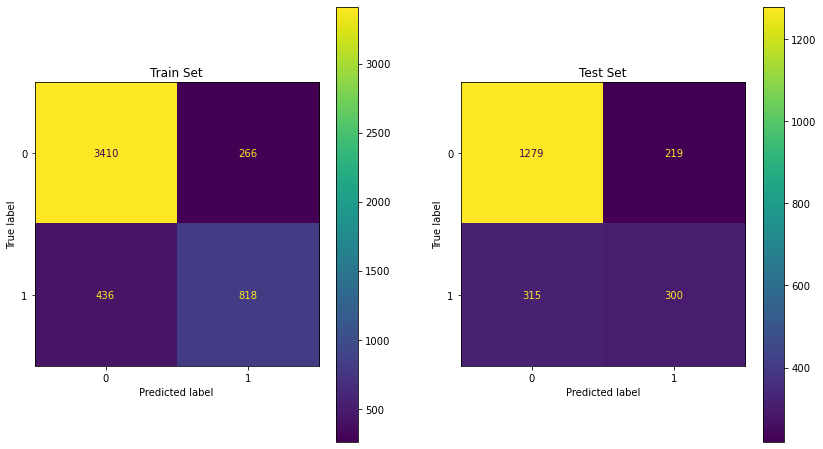

In [28]:
# plot confusion matrix
fig, ax = plt.subplots(1,2, figsize=(14,8))

plot_confusion_matrix(model,X_train_scaled,y_train,ax=ax[0], values_format = 'd')
ax[0].title.set_text("Train Set")

plot_confusion_matrix(model,X_test_scaled,y_test,ax=ax[1],values_format = 'd')
ax[1].title.set_text("Test Set")

In [29]:
CV = range(2,16)
knn_results = {}
for cv_ in CV:
    scores = cross_val_score(model, X_train, y_train, cv=cv_)
    knn_results[cv_] = scores.mean()
    print( "k="+str(cv_) + "\t"  + "mean_score = "+str(round(scores.mean(),3)) )

knn_results



k=2	mean_score = 0.757
k=3	mean_score = 0.753
k=4	mean_score = 0.759
k=5	mean_score = 0.756
k=6	mean_score = 0.757
k=7	mean_score = 0.759
k=8	mean_score = 0.759
k=9	mean_score = 0.758
k=10	mean_score = 0.757
k=11	mean_score = 0.756
k=12	mean_score = 0.757
k=13	mean_score = 0.758
k=14	mean_score = 0.759
k=15	mean_score = 0.756


{2: 0.7565922920892495,
 3: 0.7529415263653861,
 4: 0.7588242303114566,
 5: 0.7561866125760649,
 6: 0.7569964921223401,
 7: 0.7590247075619416,
 8: 0.7586200772485213,
 9: 0.7576039623338092,
 10: 0.7572008113590264,
 11: 0.755571092326382,
 12: 0.7569976064724152,
 13: 0.7582120004700201,
 14: 0.7590216971413855,
 15: 0.7557756937751747}

In [30]:
K_VAL = max(knn_results, key=knn_results.get)
K_VAL

7

## Decision Tree

In [49]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=TS,random_state=R_STATE)

In [50]:
DEPTH = 3
model = DecisionTreeClassifier(max_depth=DEPTH)

model.fit(X_train, y_train)

y_pred_train_dt = model.predict(X_train)
y_pred_test_dt  = model.predict(X_test)

In [51]:
model_eval(y_train, y_pred_train_dt, y_test, y_pred_test_dt) # get model errors

,Error_metric,Train,Test
0,Accuracy,0.735193,0.716264
1,Precision,0.707068,0.677784
2,Recall,0.813592,0.794040


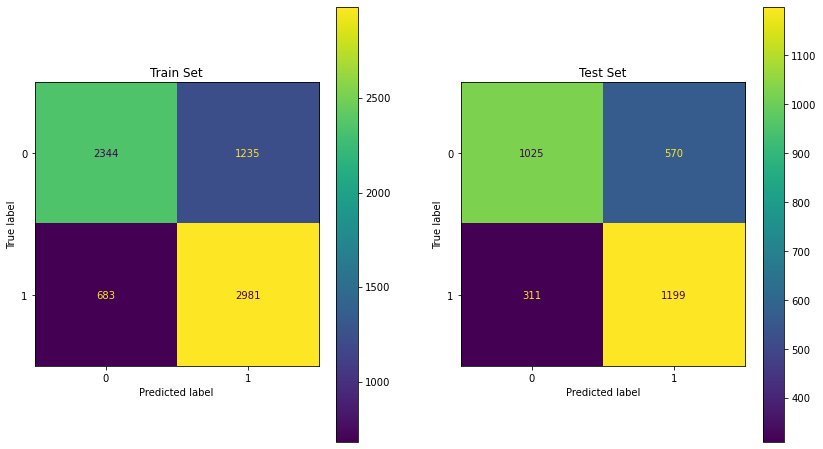

In [52]:
# confusion matrix
fig, ax = plt.subplots(1,2, figsize=(14,8))
plot_confusion_matrix(model,X_train,y_train,ax=ax[0], values_format = 'd')
ax[0].title.set_text("Train Set")
plot_confusion_matrix(model,X_test,y_test,ax=ax[1],values_format = 'd')
ax[1].title.set_text("Test Set")

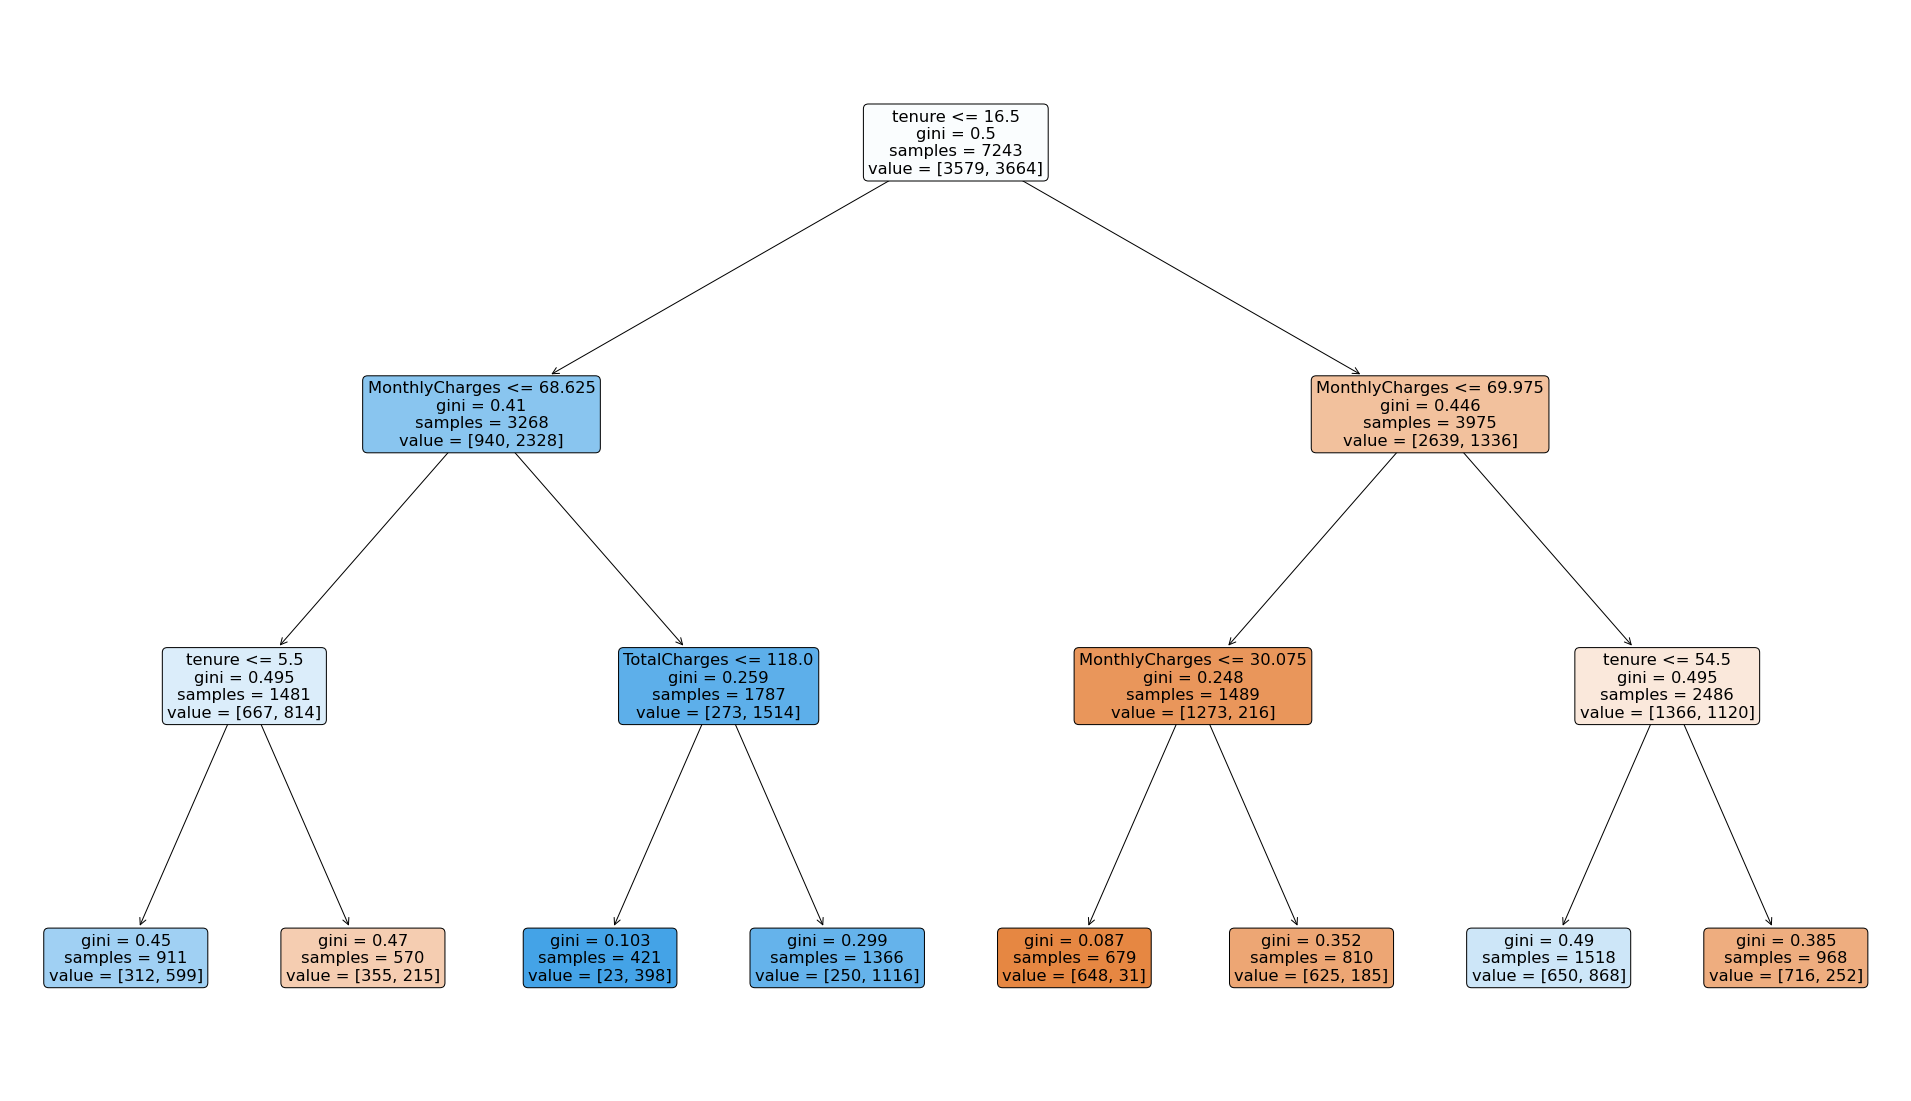

In [53]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (34,20))

plot_tree(model,filled = True, rounded=True,feature_names=X.columns)
plt.show() 

In [54]:
scores=cross_val_score(model, X_train, y_train, cv=6)
scores.mean()


0.7295279925233782

## Decision Tree Classification with Downsampled Data 

In [55]:
churn_0 = churnData[churnData['Churn'] == 0]
churn_1 = churnData[churnData['Churn'] == 1]
print(churn_0.shape,churn_1.shape)

(5174, 5) (1869, 5)


In [56]:
churn_0.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn
0,0,1,29.85,30.0,0
1,0,34,56.95,1890.0,0
3,0,45,42.30,1841.0,0
6,0,22,89.10,1949.0,0
7,0,10,29.75,302.0,0


### down sampling churn=0

In [57]:
# down sampling: get a random sampling from churn_0 matching the length of churn_1  
churn_0_down = churn_0.sample(len(churn_1)) 
print(churn_0_down.shape,churn_1.shape) # check they're the same size

(1869, 5) (1869, 5)


In [58]:
data = pd.concat([churn_0_down, churn_1], axis=0)
# shuffling the data
data = data.sample(frac=1) 
data['Churn'].value_counts()

1    1869
0    1869
Name: Churn, dtype: int64

In [59]:
data

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn
5098,1,3,77.00,238.0,1
4646,0,1,70.70,71.0,0
2334,1,16,85.05,1391.0,0
4795,0,53,20.80,1022.0,1
3111,0,72,103.40,7373.0,1
...,...,...,...,...,...
1171,0,60,94.40,5610.0,1
5378,0,58,75.80,4416.0,0
5941,0,36,34.85,1267.0,0
1552,0,31,80.55,2472.0,0


### Modeling

In [60]:
# X,y split
y = data.Churn
X = data.drop(labels=['Churn'],axis=1)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=TS,random_state=R_STATE)

model = DecisionTreeClassifier(max_depth=DEPTH)
model.fit(X_train, y_train)

y_pred_train_dt = model.predict(X_train)
y_pred_test_dt  = model.predict(X_test)

model_eval(y_train, y_pred_train_dt, y_test, y_pred_test_dt) # get model errors

,Error_metric,Train,Test
0,Accuracy,0.745031,0.712121
1,Precision,0.718981,0.679365
2,Recall,0.812121,0.779599


## Decision Tree Classification with Upsampled Data 

In [61]:
churn_0 = churnData[churnData['Churn'] == 0]
churn_1 = churnData[churnData['Churn'] == 1]
print(churn_0.shape,churn_1.shape)

(5174, 5) (1869, 5)


### upsampling churn=1

In [62]:
churn_1_up = churn_1.sample(len(churn_0), replace=True)
print(churn_1_up.shape)

(5174, 5)


In [63]:
data = pd.concat([churn_0, churn_1_up], axis=0)
#shuffling the data
data = data.sample(frac=1)
data['Churn'].value_counts()

0    5174
1    5174
Name: Churn, dtype: int64

### Modeling

In [64]:
# X,y split
y = data.Churn
X = data.drop(labels=['Churn'],axis=1)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=TS,random_state=R_STATE)

model = DecisionTreeClassifier(max_depth=DEPTH)
model.fit(X_train, y_train)

y_pred_train_dt = model.predict(X_train)
y_pred_test_dt  = model.predict(X_test)

model_eval(y_train, y_pred_train_dt, y_test, y_pred_test_dt) # get model errors

,Error_metric,Train,Test
0,Accuracy,0.727737,0.714332
1,Precision,0.694399,0.671291
2,Recall,0.819753,0.822760


In [71]:
[cross_val_score(model, X_train, y_train, cv=c).mean() for c in range(2,10)]


[0.7242857595982451,
 0.7241473850205523,
 0.7245625261218276,
 0.7238716737395574,
 0.7255303179941878,
 0.7224924012158055,
 0.7255312953544815,
 0.7223540681684743]